<a href="https://colab.research.google.com/github/ahmadpnb/combinationforecast/blob/main/Anis_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 25.2 MB/s eta 0:00:00


In [ ]:
#packages needed for this script

import pandas as pd #package for data handling
import numpy as np #package for default arithmetic
import seaborn as sns #package for plotting graph
import matplotlib.pyplot as plt #package for plotting graph
import statsmodels.api as sm #package for models and other statistical test
from statsmodels.tsa.api import VAR #package for VAR model
from statsmodels.tsa.vector_ar.vecm import VECM #package for VECM model
from statsmodels.tsa.ar_model import ar_select_order #package to select lag order
from statsmodels.tsa.stattools import adfuller #package for ADF test for stationarity
from arch.unitroot import PhillipsPerron #package for Phillips Perron test for stationarity
from statsmodels.tsa.stattools import kpss #package for KPSS test for stationarity
from statsmodels.stats.diagnostic import het_breuschpagan #package for Breusch Pagan test for heteroscedasticity
from statsmodels.tsa.stattools import grangercausalitytests #package for granger causality tests
from sklearn.model_selection import train_test_split #package for train test split
from statsmodels.tools.eval_measures import rmse, aic #package for accuracy test
from statsmodels.tsa.arima.model import ARIMA #package for ARIMA

In [ ]:
# Functions for EDA

def eda(df):
  print(df.info())
  print()
  print()
  display(df.head(10), df.tail(10))
  print()
  print()
  print('Data summary statistics')
  display(df.describe())
  print()
  print()
  df.select_dtypes(include = np.number).plot(subplots = True, sharex = True, figsize = (11.69,8.27), use_index = True, title = "Graphs of all variables", legend = True, xlabel = "Date")
  plt.show()
  print()
  print()
  pairplot = sns.pairplot(data = df.select_dtypes(include = np.number), kind = "reg", diag_kind = "hist", dropna = True)
  pairplot.fig.subplots_adjust(top = .95)
  pairplot.fig.suptitle("Variables distribution and two way relationships")
  plt.show()
  print()
  print()
  sns.heatmap(data = df.corr(numeric_only = True), cmap = "RdYlGn", center = 0, robust = True, square = True, annot = True, fmt = ".0%", linewidth = 0.5)
  plt.title("Correlation matrix between variables")
  plt.show()

In [ ]:
# functions for transformation

# function to log selected columns
def transform_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].transform(np.log)

  return df


# function to difference selected columns
def transform_diff(df, second_diff = False):

  print(df.columns)
  input_string = input("Enter all columns' name to be diff separated by space: ")
  columns = input_string.split(" ")

  second_diff = int(input("1 if need second difference, 0 if do not need second difference: "))

  for i in columns:
    print("Column: " + i)
    df[i] = df[i].diff(int(input("Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  if second_diff == True:
      print(df.columns)
      input_string_2 = input("Enter all columns' name to be second differenced separated by space: ")
      columns_2 = input_string_2.split(" ")

      for i in columns_2:
        print("Column: " + i)
        df[i] = df[i].diff(int(input("Please enter the number of second difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  return df


# function to perform data transformation
def transform_data(df, to_log = False, to_diff = False):

  transform = df.copy()
  to_log = int(input("1 if need to log, 0 if no need to log: "))
  to_diff = int(input("1 if need to diff, 0 if no need to diff: "))

  if to_log == True and to_diff == False:
    transform_log(transform)

  elif to_log == False and to_diff == True:
    transform_diff(transform)

  elif to_log == True and to_diff == True:
    transform_log(transform)
    transform_diff(transform)

  return transform


# function to invert differenced columns
def invert_diff(original_df, differenced_df, second_diff = False):

    second_diff = int(input("1 if need to undo second differencing, 0 if only inversing first difference: "))

    print("Please log the variables that was log before differenced")
    original_df = transform_log(original_df)

    if second_diff == True:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo second differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        second_d = int(input("Please insert the number of difference for the second difference: "))
        diff = original_df[i].diff(first_d)
        first_invert = diff.shift(second_d) + differenced_df[i]
        second_invert = original_df[i].shift(first_d) + first_invert
        differenced_df[i] = second_invert

      print(original_df.columns)
      input_string2 = input("Enter all columns' name to undo first differencing other than previously listed separated by space: ")
      columns_2 = input_string2.split(" ")

      for i in columns_2:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    elif second_diff == False:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo first differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    return differenced_df


# Function to invert log transformation
def invert_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be inverted its log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].apply(np.exp)

  return df


# Function to perform inverse transformation
def inverse_transformation(original_data, differenced_data, log = False, diff = False):

  original_data = original_data.copy()
  differenced_data = differenced_data.copy()

  log = int(input("1 if need to invert log, 0 if no need to invert log: "))
  diff = int(input("1 if need to invert diff, 0 if no need to invert diff: "))

  if diff == True and log == True:
    invert_data = invert_diff(original_data, differenced_data)
    invert_data = invert_log(invert_data)

  elif diff == True and log == False:
    invert_data = invert_diff(original_data, differenced_data)

  elif diff == False and log == True:
    invert_data = invert_log(differenced_data)

  else:
    invert_data = differenced_data

  return invert_data

In [ ]:
# Functions for testing

# function for colour formatting for pvalue - hypothesis testing
def pvalue_formatting(col):
    if col.name == '10%':
        return ['background-color: green' if c < 0.1 else 'background-color: red' for c in col.values]
    if col.name == '5%':
        return ['background-color: green' if c < 0.05 else 'background-color: red' for c in col.values]
    if col.name == '1%':
        return ['background-color: green' if c < 0.01 else 'background-color: red' for c in col.values]

def pvalue_formatting2(col):
    if col.name == '10%':
        return ['background-color: red' if c < 0.1 else 'background-color: green' for c in col.values]
    if col.name == '5%':
        return ['background-color: red' if c < 0.05 else 'background-color: green' for c in col.values]
    if col.name == '1%':
        return ['background-color: red' if c < 0.01 else 'background-color: green' for c in col.values]


# function to perform ADF test
def adf_test(df):

  indicator = []
  pvalue = []

  for column in df:
    adf = adfuller(df[column], regression = 'ct')
    p_value = adf[1]
    indicator.append(column)
    pvalue.append(p_value)

  adf_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("ADF test for stationarity: H0 is time series is not stationary")
  display(adf_test)


# Function to perform Phillips Perron test
def pp_test(df):

  indicator = []
  pvalue = []

  for column in df:
    pp = PhillipsPerron(df[column])
    p_value = pp.pvalue
    indicator.append(column)
    pvalue.append(p_value)

  pp_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("PP test for stationarity: H0 is time series is not stationary")
  display(pp_test)


# Function to perform KPSS test
def kpss_test(df):

  indicator = []
  pvalue = []

  for column in df:
    kpss_test = kpss(df[column], regression = 'ct')
    p_value = kpss_test[1]
    indicator.append(column)
    pvalue.append(p_value)

  kpss_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  print("KPSS test for stationarity: H0 is time series is stationary")
  display(kpss_test)


# Function to perform all stationarity test
def stationarity_test(df):

  print("Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise")
  print()
  adf_test(df)
  print()
  pp_test(df)
  print()
  kpss_test(df)


# Function to estimate ACF and PACF for autocorrelation
def acf_pacf_analysis(x, max_lags=24):
    acf_values = sm.tsa.acf(x)
    pacf_values = sm.tsa.pacf(x)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sm.graphics.tsa.plot_acf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('ACF')

    plt.subplot(1, 2, 2)
    sm.graphics.tsa.plot_pacf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('PACF')

    plt.tight_layout()
    plt.suptitle("ACF and PACF graph for " + x.name)
    plt.show()


# Function to graph ACF and PACF
def acf_pacf_graph(df):
  for column in df:
    acf_pacf_analysis(df[column])

# Function for accuracy testing
def forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',input("Please put model name: ")," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

# Function for random walk accuracy testing
def rw_forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',"Random walk model"," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

def adjust(val, length= 6): return str(val).ljust(length)


# Function to find the optimal lag for VECM model

def vecm_optimal_lag(df):

  if df.index.freq == 'm':
    lags = 12
    seasons = 12
  elif df.index.freq == 'q':
    lags = 4
    seasons = 4

  deterministic = input("n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept): ")

  result = select_order(df, deterministic = deterministic, maxlags = lags, seasons = seasons)
  print()
  print()
  print(result.summary())
  print()
  print()
  lag = [result.aic, result.bic, result.fpe, result.hqic]
  if len(st.multimode(lag)) != 1:
    optimal_lag = result.aic
  elif len(st.multimode(lag)) == 1:
    optimal_lag = st.mode(lag)
  print("The optimal lag for the model is",optimal_lag)

  return optimal_lag


# Functio to test cointegraion rank

def cointegration_test(df):

  lag = int(input("Insert optimal lag number obtained from test: "))
  deterministic = int(input("-1 - no deterministic terms, 0 - constant term, 1 - linear trend "))
  result = coint_johansen(df, det_order = deterministic, k_ar_diff = lag)
  null = ['r = 0', 'r <= 1', 'r <= 2']
  trace_stat = result.trace_stat.tolist()
  trace_stat_crit_vals = result.trace_stat_crit_vals.tolist()
  a,b,c = trace_stat_crit_vals
  max_eig_stat = result.max_eig_stat.tolist()
  max_eig_stat_crit_vals = result.max_eig_stat_crit_vals.tolist()
  d,e,f = trace_stat_crit_vals
  table = pd.DataFrame({'Null Hypothesis of cointegration rank':null,'Trace statistic':trace_stat,'Trace statistic critical values at 99%':a,'Trace statistic critical values at 95%':b,'Trace statistic critical values at 90%':c,'Maximum eigenvalue statistic':max_eig_stat,'Maximum eigenvalue statistic critical values at 99%':d,'Maximum eigenvalue statistic critical values at 95%':e,'Maximum eigenvalue statistic critical values at 90%':f})
  print()
  print()
  display(table)
  print()
  print()
  trace_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "trace")
  print(trace_coint_rank_result.summary())
  print("Trace method cointegration test suggest a cointegration rank of",trace_coint_rank_result.rank)
  print()
  print()
  maxeig_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "maxeig")
  print(maxeig_coint_rank_result.summary())
  print("Maximum Eigenvalue method cointegration test suggest a cointegration rank of",maxeig_coint_rank_result.rank)
  rank = [trace_coint_rank_result.rank, maxeig_coint_rank_result.rank]
  if trace_coint_rank_result.rank != maxeig_coint_rank_result.rank:
    coint_rank = trace_coint_rank_result.rank
  else:
    coint_rank = st.mode(rank)

  return coint_rank

In [ ]:
# Function to perform VAR model with automatice lag order selection

def var_model(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by comma: ").lower()
  variables_list  = variables_input.split(",")
  main_endog = input("Please enter the name of your main endogenous variables: ")
  var_list = variables_list.copy()
  var_list.remove(main_endog)

  '''if main_endog in variables_list:
        var_list = variables_list.copy()
        var_list.remove(main_endog)
  else:
      print(f"{main_endog} is not found in the list of variables.")
  '''

  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print("Model parameter setting and fitting")

  lags = 1  # Assign a default value


  if transformed_df.index.freq == 'm':
    lags = 12
  elif transformed_df.index.freq == 'q':
    lags = 4

  model = VAR(transformed_df)
  fit = model.fit(maxlags = lags, ic = 'aic', verbose = True, trend = 'c')
  residual = fit.resid[main_endog]
  predict = fit.fittedvalues[main_endog].to_frame(name = main_endog)
  actual = og_df.loc[predict.index[0]:predict.index[-1]]
  exog_het = actual[var_list]

  # Create a DataFrame for exog_het with a constant and your explanatory variable(s)
  # exog_het_df = pd.DataFrame({
  # 'constant': np.ones(len(exog_het)),  # Add a constant column of ones
  # 'exog_variable1': exog_het['exog_variable1'],  # Replace 'exog_variable1' with the actual column name
  # Add more explanatory variables as needed
 #})

  random_walk_model = ARIMA(og_df[main_endog], order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_residual = randow_walk_fit.resid
  random_walk_predict = randow_walk_fit.predict().to_frame(name = main_endog)
  random_walk_actual = og_df.loc[random_walk_predict.index[0]:random_walk_predict.index[-1]]

  print()
  print("Inversing model fitted value")
  predict = inverse_transformation(og_df, predict)

  normality_test = fit.test_normality()

  whiteness_test = fit.test_whiteness(nlags = 24)

  stability_test = fit.is_stable()

  print()
  print()
  print()
  print(fit.summary())
  print()
  print()
  print()
  print("Series of test to identify model's robustness: Green cells indicate passing of the test or there will be statement indicating the conclusion of the test")

  print()
  print(normality_test.summary())
  print()
  print()
  print(whiteness_test.summary())
  print()
  print()
  print("Is coefficient of the model is stable according to the eigenvalues of the companion matrix:",stability_test)
  print()
  print()
  fit.plot_acorr(nlags = 24)
  plt.tight_layout()
  plt.show()
  print()
  print()
  print()
  print(fit.test_inst_causality(var_list).summary())
  print()
  print()
  for i in var_list:
    gran_causality = fit.test_causality(main_endog, i)
    print(gran_causality.summary())
    print()
    print()
  print(fit.test_causality(main_endog,var_list))
  print()
  print()
  print()
  fit.irf(24).plot(response = main_endog)
  plt.tight_layout()
  plt.show()
  print()
  print()
  fit.irf(24).plot_cum_effects(response = main_endog)
  plt.tight_layout()
  plt.show()
  print()
  print()
  print()
  fit.fevd(periods = 12).plot()
  plt.tight_layout()
  plt.show()
  print()
  print()
  print()
  print()
  plt.plot(actual[main_endog], color = "mediumblue", label = 'Actual')
  plt.plot(predict, color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_predict, color = "red", label = 'Random walk')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Model fitting versus actual data")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(predict,actual[main_endog])
  print()
  print()
  rw_forecast_accuracy(random_walk_predict, random_walk_actual[main_endog])

  return model, fit, predict, residual, actual

In [ ]:
# function to calculate RMSE four quarter ahead

def rmse_four_quarters_ahead(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze() # not sure
    actual = actual.squeeze() # not sure
    forecast_four_quarters = forecast[:4]
    actual_four_quarters = actual[:4]
    rmse = np.mean((forecast_four_quarters - actual_four_quarters)**2)**0.5  # RMSE for four quarters ahead
    return rmse

In [ ]:
# Function for cross validation

def var_simple_validation(actual):
  # Define and assign a value to 'lags' here
  lags = 4  # You can replace 3 with the desired number of lags

  actual = actual.copy()

  print("Splitting dataset into train and test sets")
  train, test = train_test_split(actual, test_size = float(input("Please put the desired size of your test data in decimal i.e. 20% put 0.2: ")), shuffle = False)

  print()
  print("Sample transformation")
  transformed_df = transform_data(train).dropna()

  main_endog = input("Please enter the name of your main endogenous variables: ")
  var_list = transformed_df.copy().columns.values.tolist()
  var_list.remove(main_endog)

  print()
  print("Model parameter setting and fitting")

  if transformed_df.index.freq == 'm':
    lags = 12
  elif transformed_df.index.freq == 'q':
    lags = 4

  train_model = VAR(transformed_df)
  train_fit = model.fit(maxlags = lags, ic = 'aic', verbose = True, trend = 'c')
  test_forecast = pd.DataFrame(train_fit.forecast(steps = len(test), y = model.endog), columns = model.endog_names, index = test.index)

  random_walk_model = ARIMA(train[main_endog], order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_forecast = randow_walk_fit.forecast(steps = len(test)).to_frame(name = main_endog)

  print()
  print("Inversing model fitted value")
  test_forecast = inverse_transformation(actual, test_forecast)

  print()
  print()
  plt.plot(actual[main_endog], color = "mediumblue", label = 'Actual')
  plt.plot(test_forecast[main_endog], color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_forecast, color = "red", label = 'Random walk')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Forecast generated from train datasets")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(test_forecast[main_endog], test[main_endog])
  print()
  print()
  rw_forecast_accuracy(random_walk_forecast, test[main_endog])

  # Calculate RMSE for four quarters ahead for the VAR model fitting
  rmse_var_model = rmse_four_quarters_ahead(test_forecast[main_endog], test[main_endog])
  print("RMSE for Four Quarters Ahead (VAR Model Fitting):", rmse_var_model)

  # Calculate RMSE for four quarters ahead for the random walk model
  rmse_random_walk = rmse_four_quarters_ahead(random_walk_forecast, test[main_endog])
  print("RMSE for Four Quarters Ahead (Random Walk):", rmse_random_walk)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#code to read original data

path = '/content/drive/MyDrive/Internship/USDFAST.xlsx'
sheet = input("Please put your sheet name here: ")
data = pd.read_excel(path, sheet_name = sheet, index_col = 'Date')

Please put your sheet name here: forecastq


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1985-01-31 to 2024-12-31
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Period    480 non-null    object 
 1   m2_us     459 non-null    float64
 2   ipi_us    461 non-null    float64
 3   ir_us     462 non-null    float64
 4   cpi_us    461 non-null    float64
 5   ca_us     301 non-null    float64
 6   ir10y_us  462 non-null    float64
 7   ir3y_us   451 non-null    float64
 8   ir2y_us   462 non-null    float64
 9   ir1y_us   381 non-null    float64
dtypes: float64(9), object(1)
memory usage: 41.2+ KB
None




,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
1985-01-31,1Q1985,NaN,59.455503,8.25,48.382178,NaN,11.355650,10.326085,9.890550,8.983450
1985-02-28,1Q1985,27.290406,60.310981,9.00,48.611477,NaN,11.405077,10.434923,10.053077,9.154333
1985-03-31,1Q1985,27.430678,60.386510,8.50,48.794917,NaN,11.822000,10.972839,10.675000,9.813556
1985-04-30,2Q1985,27.537331,59.316562,8.25,49.024216,NaN,11.402381,10.397929,10.054619,9.118524
1985-05-31,2Q1985,27.700788,59.277924,7.75,49.207656,NaN,10.821636,9.697791,9.365318,8.422318
1985-06-30,2Q1985,27.968580,60.600652,7.75,49.345236,NaN,10.142053,8.992042,8.663947,7.774632
1985-07-31,3Q1985,28.164497,58.047643,7.75,49.436955,NaN,10.283182,9.093023,8.747682,7.822455
1985-08-31,3Q1985,28.332591,59.710575,8.00,49.528675,NaN,10.319409,9.272277,8.920318,8.024273
1985-09-30,3Q1985,28.476341,60.572056,8.00,49.666255,NaN,10.336400,9.302610,8.952650,8.028950


,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
2024-03-31,1Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-31,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-31,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,4Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-30,4Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Data summary statistics


,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
count,459.000000,461.000000,462.000000,461.000000,301.000000,462.000000,451.000000,462.000000,381.000000
mean,90.735899,93.265883,3.411667,87.473926,-3.062558,4.829704,4.018576,3.784575,3.594212
std,60.220324,17.681544,2.719126,23.289842,1.345253,2.455149,2.727231,2.747084,2.885312
min,27.290406,58.047643,0.250000,48.382178,-5.940000,0.616700,0.157114,0.114290,0.039371
25%,40.415096,76.249525,0.500000,68.331228,-4.130000,2.707273,1.437186,1.003404,0.409664
50%,71.296345,100.007977,3.000000,85.941423,-2.693333,4.535534,4.115240,3.899264,3.584043
75%,126.353618,108.118864,5.500000,107.126855,-2.060000,6.603683,6.144509,5.914023,5.841591
max,251.605929,115.784659,9.750000,139.472290,-0.890000,11.822000,10.972839,10.675000,9.813556


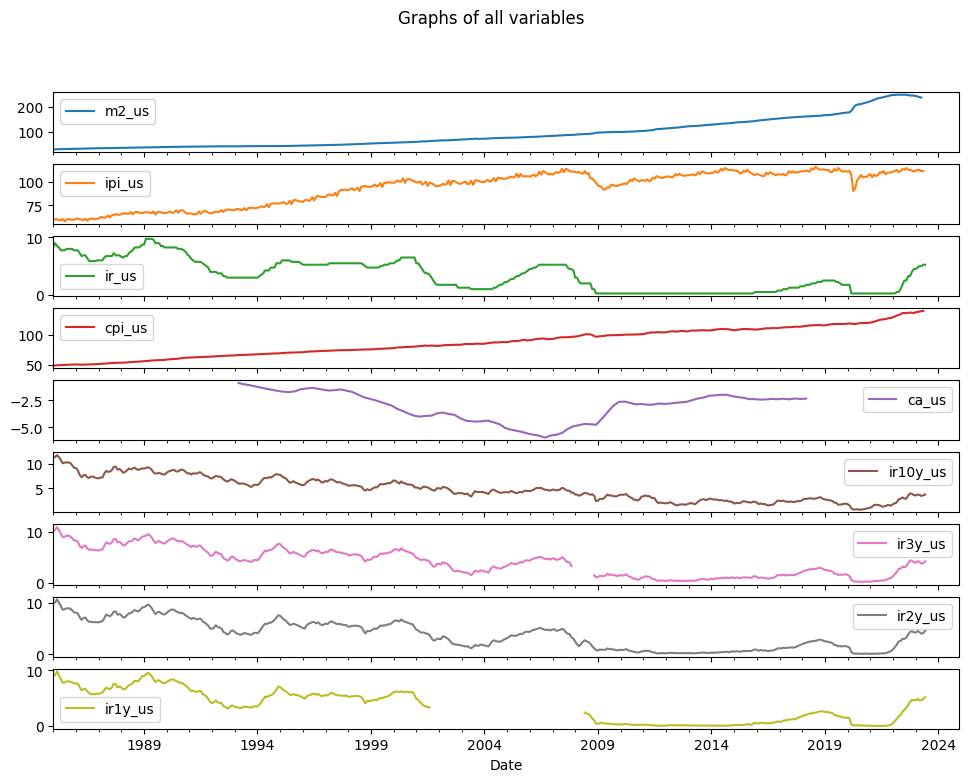

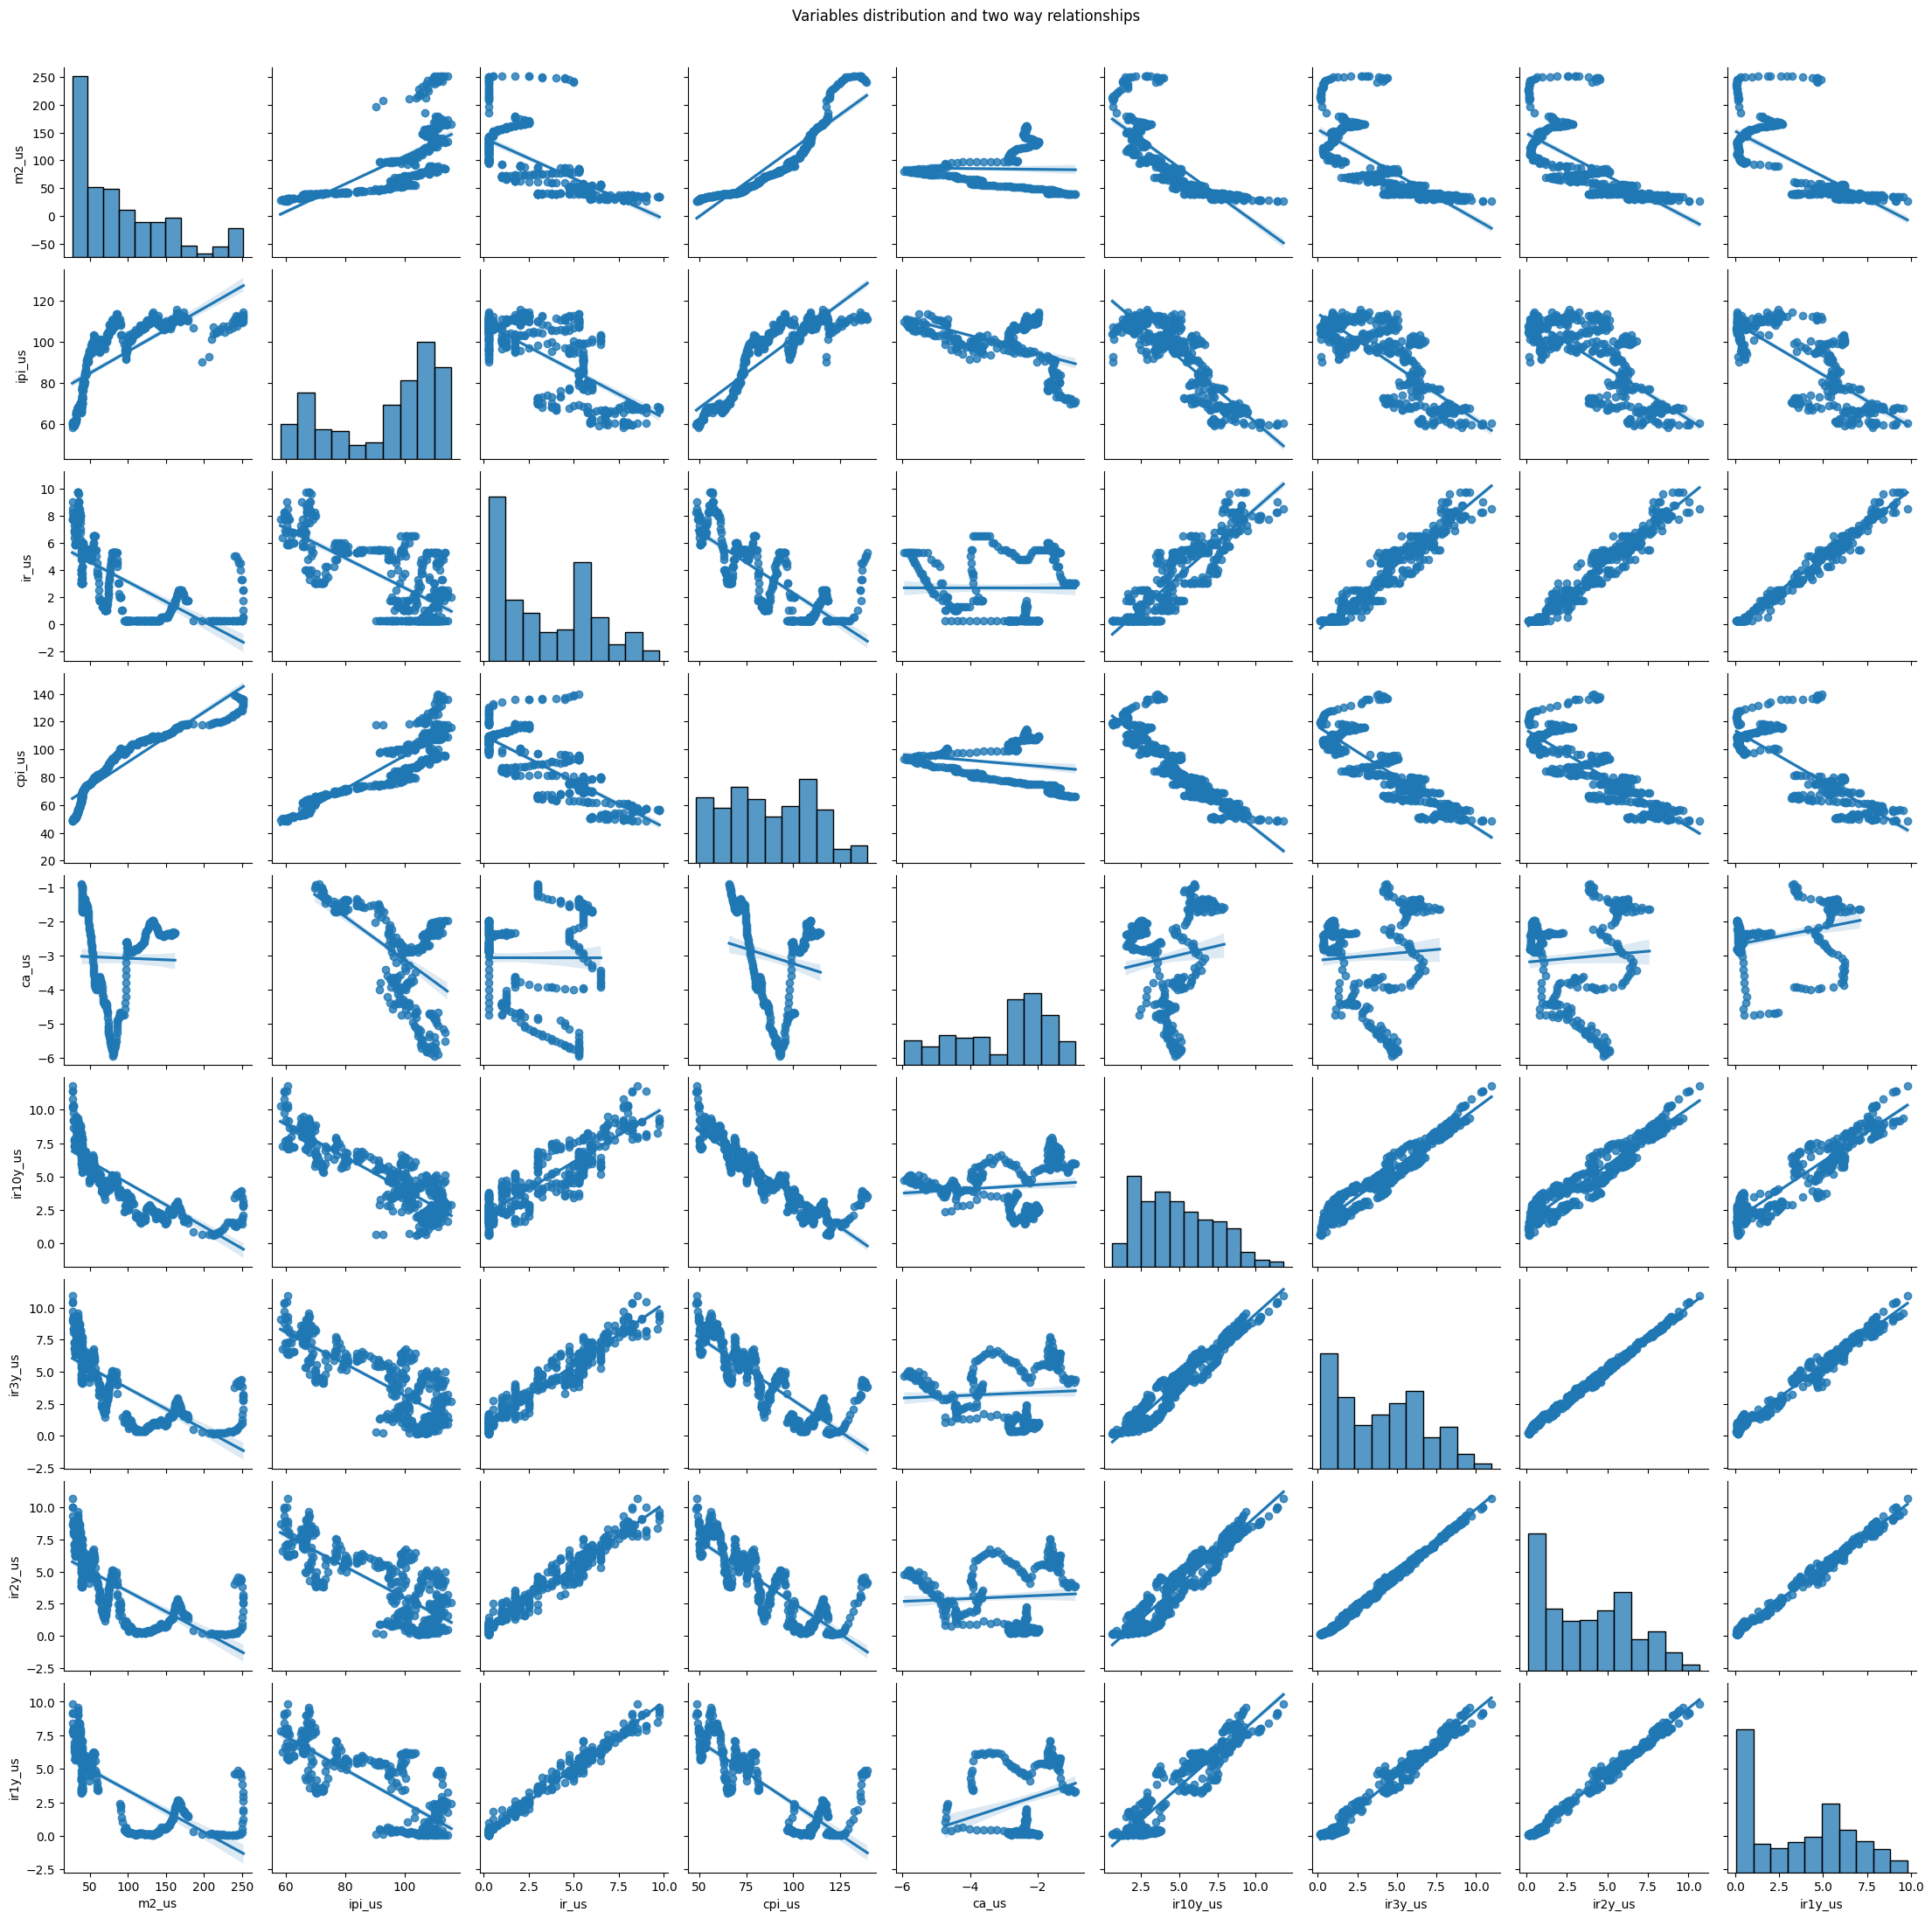

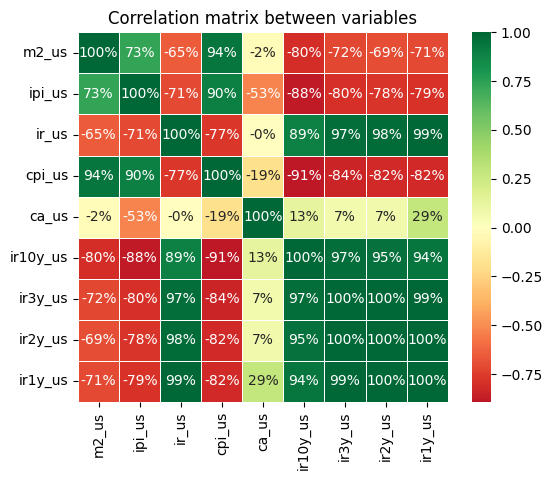

In [ ]:
#code to show exploratory data analysis

eda(data)

In [ ]:
#code to create specific dataframe for testing purposes to ensure no changes to original dataframe

var_df = pd.DataFrame(data[input('Please put the columns you want to use for this VAR model seperated by space: ').split(" ")].copy(deep = True)).loc[input('Please insert model sample start date in YYYY-MM-DD format '):input('Please insert model sample end date in YYYY-MM-DD format ')].dropna()

Please put the columns you want to use for this VAR model seperated by space: cpi_us m2_us ipi_us ir10y_us
Please insert model sample start date in YYYY-MM-DD format 1990-01
Please insert model sample end date in YYYY-MM-DD format 2023-06


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1990-03-01 to 2023-06-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cpi_us    134 non-null    float64
 1   m2_us     134 non-null    float64
 2   ipi_us    134 non-null    float64
 3   ir10y_us  134 non-null    float64
dtypes: float64(4)
memory usage: 5.2 KB
None




,cpi_us,m2_us,ipi_us,ir10y_us
Date,,,,
1990-03-01,58.954621,36.863361,62.089667,8.413469
1990-06-01,59.504314,37.136072,62.396667,8.665538
1990-09-01,60.786932,37.608694,63.050233,8.687446
1990-12-01,61.290818,37.807450,61.787267,8.392924
1991-03-01,61.840511,38.386383,60.572200,8.012258
1991-06-01,62.298589,38.733049,61.080600,8.117554
1991-09-01,62.848282,38.767716,62.148900,7.945470
1991-12-01,63.168937,38.967627,61.846000,7.334803
1992-03-01,63.810246,39.333938,61.957567,7.296875


,cpi_us,m2_us,ipi_us,ir10y_us
Date,,,,
2021-03-01,121.334289,229.273676,97.765400,1.312202
2021-06-01,124.457922,236.963895,98.607333,1.579955
2021-09-01,125.655338,242.249403,100.232833,1.317730
2021-12-01,127.713023,249.014023,100.374400,1.528845
2022-03-01,131.699217,250.734644,102.161467,1.945875
2022-06-01,135.733509,250.368333,102.199500,2.924622
2022-09-01,135.961173,248.723978,103.748933,3.096858
2022-12-01,135.956134,246.804601,102.319667,3.815849
2023-03-01,138.264389,240.821137,102.870967,3.647702




Data summary statistics


,cpi_us,m2_us,ipi_us,ir10y_us
count,134.000000,134.000000,134.000000,134.000000
mean,92.922789,100.293003,89.556081,4.239228
std,20.536998,60.815579,13.115845,2.006317
min,58.954621,36.863361,60.572200,0.645314
25%,74.735403,48.590801,84.528650,2.519350
50%,92.943998,80.980142,93.108317,4.151907
75%,108.834719,136.775250,99.739692,5.879606
max,141.298582,250.734644,104.672133,8.687446


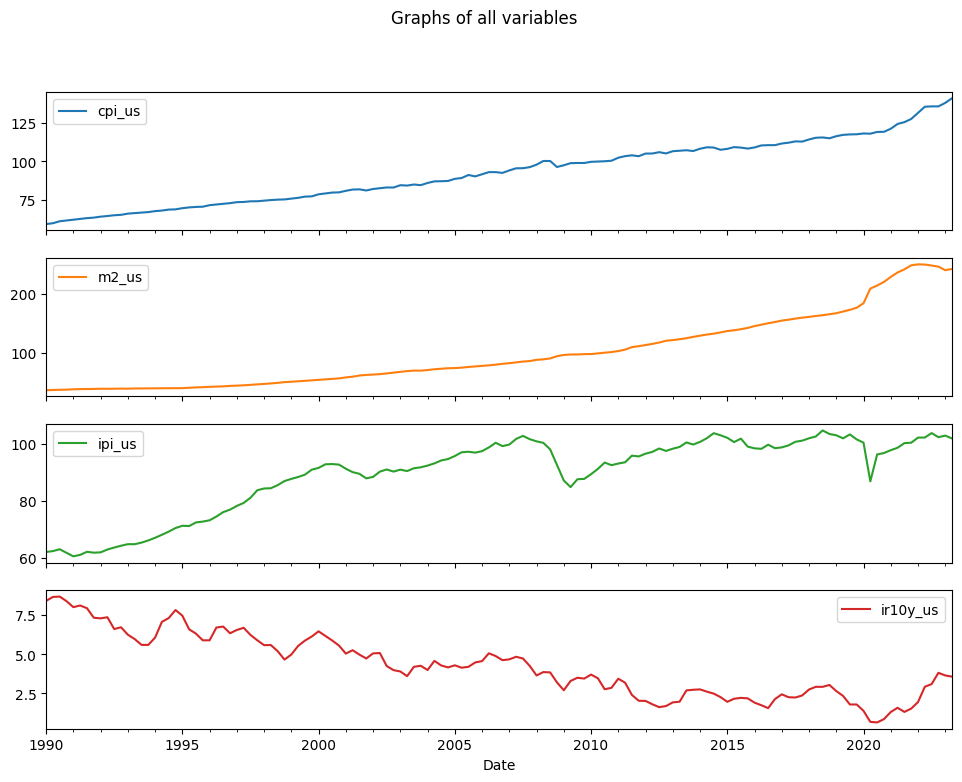

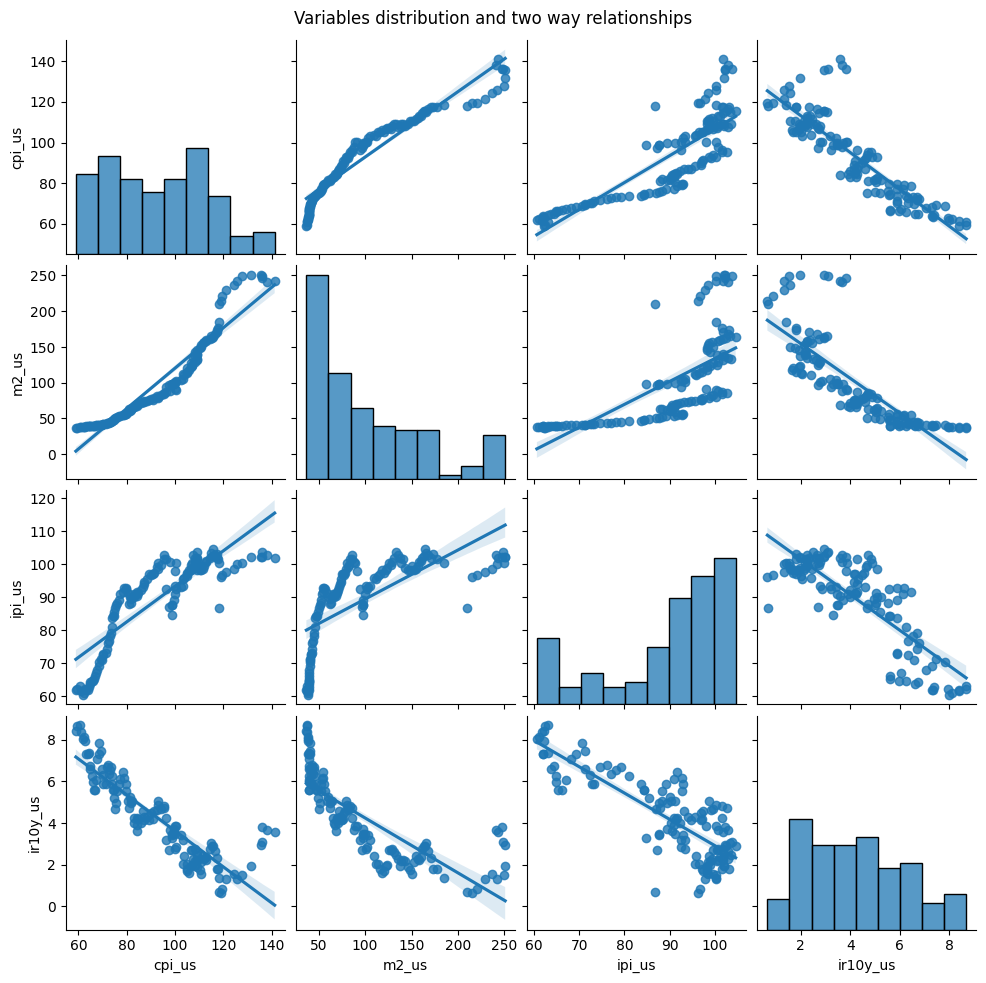

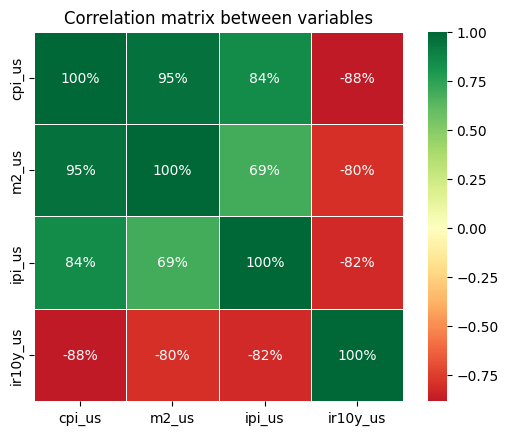

In [ ]:
#code for EDA

eda(var_df)

Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise

ADF test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,cpi_us,0.946356,0.946356,0.946356
1,m2_us,1.000000,1.000000,1.000000
2,ipi_us,0.735581,0.735581,0.735581
3,ir10y_us,0.035742,0.035742,0.035742



PP test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,cpi_us,0.998566,0.998566,0.998566
1,m2_us,1.000000,1.000000,1.000000
2,ipi_us,0.309926,0.309926,0.309926
3,ir10y_us,0.244427,0.244427,0.244427



KPSS test for stationarity: H0 is time series is stationary


<ipython-input-5-87a2ba453351>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-5-87a2ba453351>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')


,Indicator,10%,5%,1%
0,cpi_us,0.079783,0.079783,0.079783
1,m2_us,0.010000,0.010000,0.010000
2,ipi_us,0.010000,0.010000,0.010000
3,ir10y_us,0.020682,0.020682,0.020682


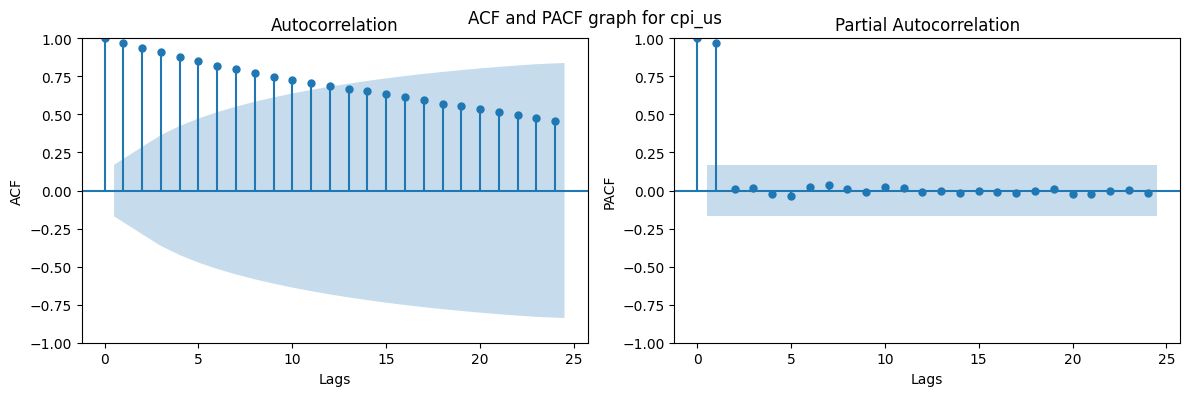

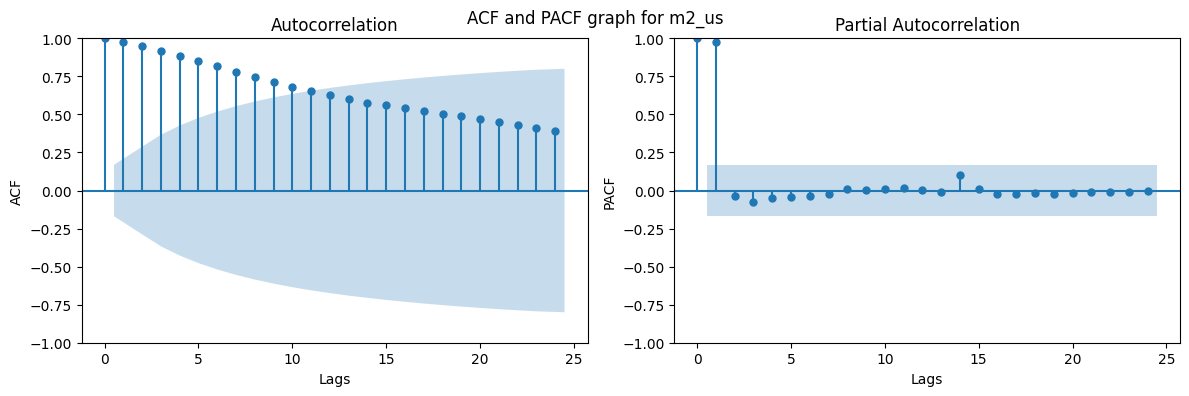

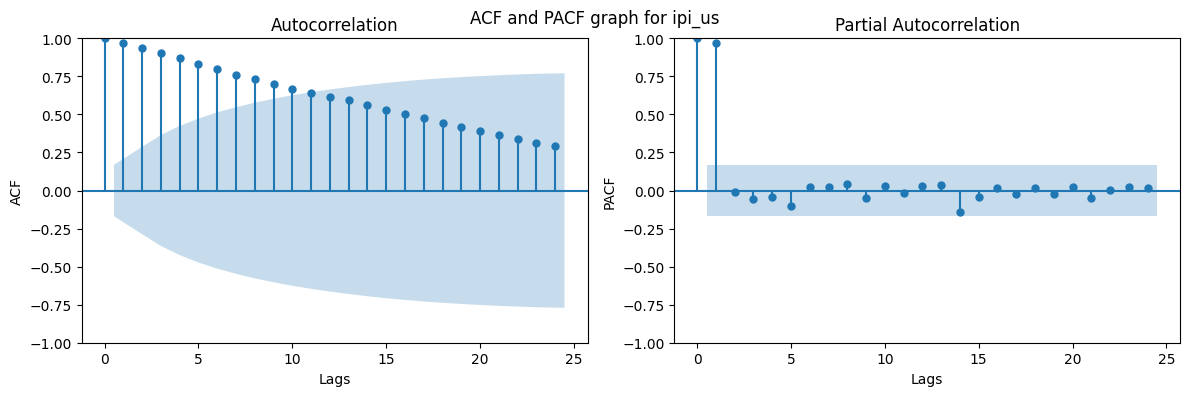

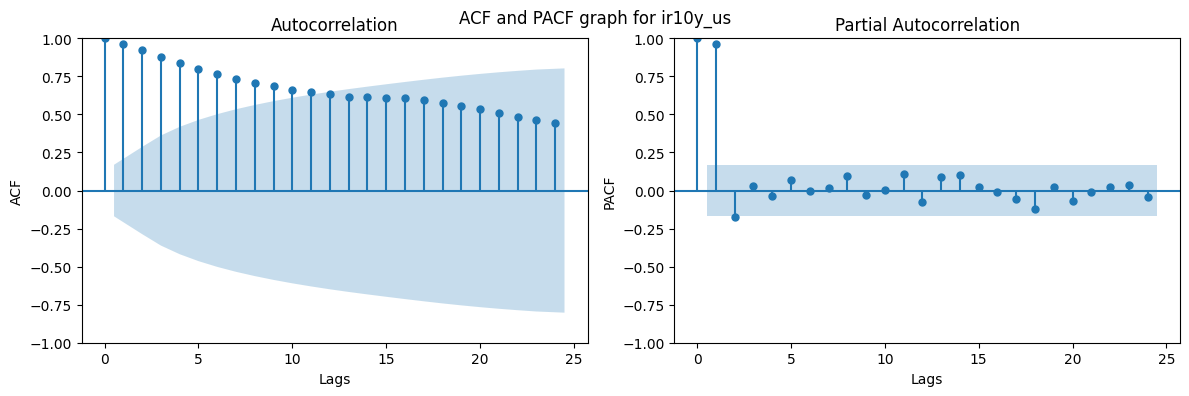

In [ ]:
# code to do stationary test

stationarity_test(var_df)
print()
print()
acf_pacf_graph(var_df)

In [ ]:
# code to transform data, dropna is optional

var_df_transformed = transform_data(var_df).dropna()

1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1990-03-01 to 2023-06-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cpi_us    134 non-null    float64
 1   m2_us     134 non-null    float64
 2   ipi_us    134 non-null    float64
 3   ir10y_us  134 non-null    float64
dtypes: float64(4)
memory usage: 5.2 KB
None




,cpi_us,m2_us,ipi_us,ir10y_us
Date,,,,
1990-03-01,58.954621,36.863361,62.089667,8.413469
1990-06-01,59.504314,37.136072,62.396667,8.665538
1990-09-01,60.786932,37.608694,63.050233,8.687446
1990-12-01,61.290818,37.807450,61.787267,8.392924
1991-03-01,61.840511,38.386383,60.572200,8.012258
1991-06-01,62.298589,38.733049,61.080600,8.117554
1991-09-01,62.848282,38.767716,62.148900,7.945470
1991-12-01,63.168937,38.967627,61.846000,7.334803
1992-03-01,63.810246,39.333938,61.957567,7.296875


,cpi_us,m2_us,ipi_us,ir10y_us
Date,,,,
2021-03-01,121.334289,229.273676,97.765400,1.312202
2021-06-01,124.457922,236.963895,98.607333,1.579955
2021-09-01,125.655338,242.249403,100.232833,1.317730
2021-12-01,127.713023,249.014023,100.374400,1.528845
2022-03-01,131.699217,250.734644,102.161467,1.945875
2022-06-01,135.733509,250.368333,102.199500,2.924622
2022-09-01,135.961173,248.723978,103.748933,3.096858
2022-12-01,135.956134,246.804601,102.319667,3.815849
2023-03-01,138.264389,240.821137,102.870967,3.647702




Data summary statistics


,cpi_us,m2_us,ipi_us,ir10y_us
count,134.000000,134.000000,134.000000,134.000000
mean,92.922789,100.293003,89.556081,4.239228
std,20.536998,60.815579,13.115845,2.006317
min,58.954621,36.863361,60.572200,0.645314
25%,74.735403,48.590801,84.528650,2.519350
50%,92.943998,80.980142,93.108317,4.151907
75%,108.834719,136.775250,99.739692,5.879606
max,141.298582,250.734644,104.672133,8.687446


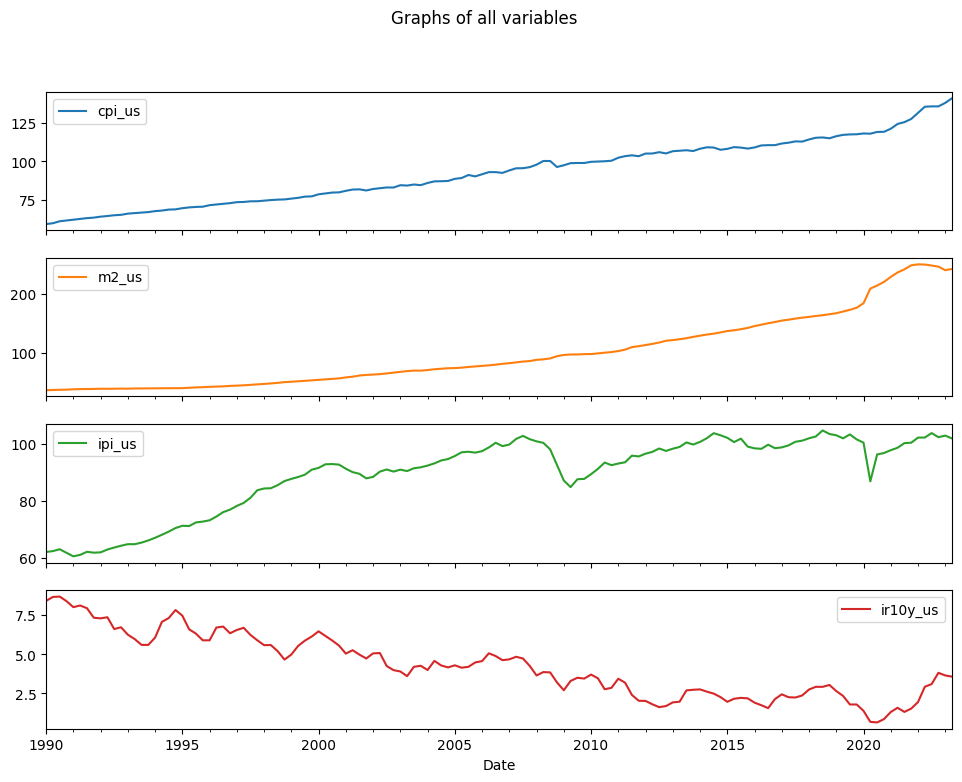

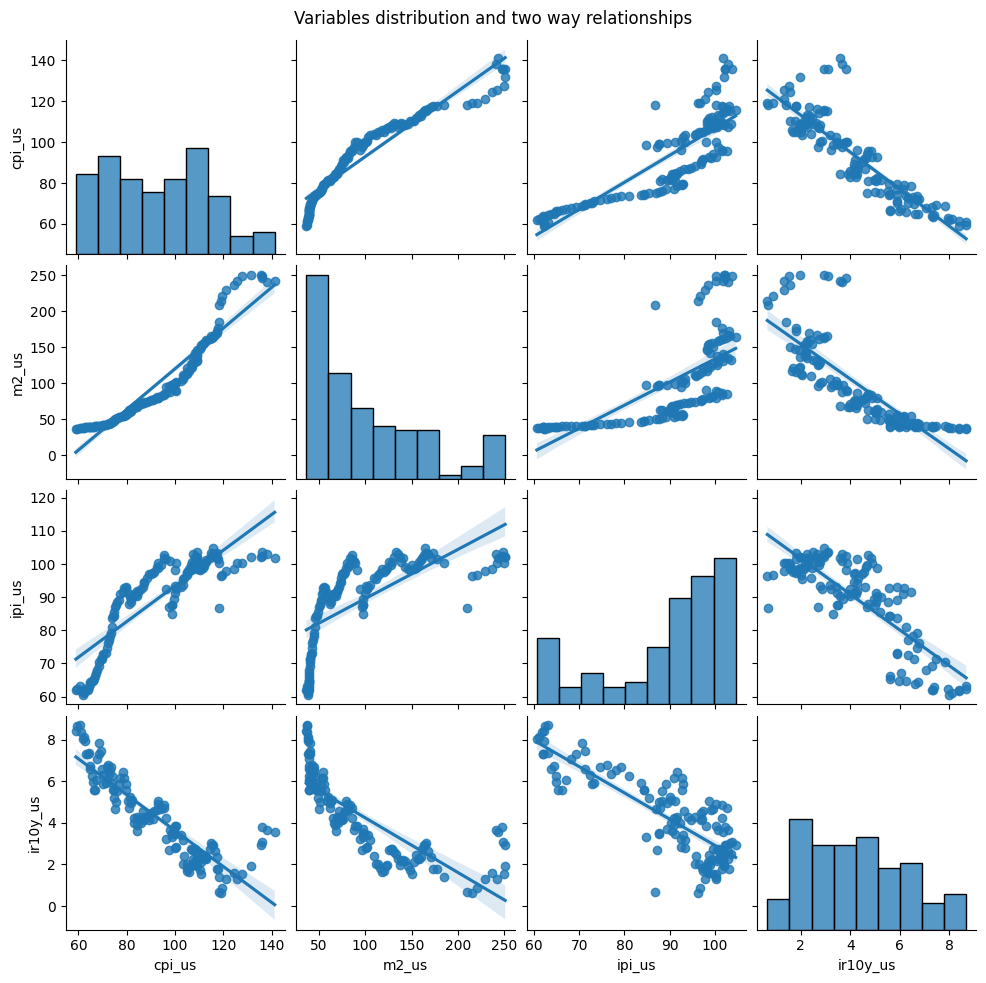

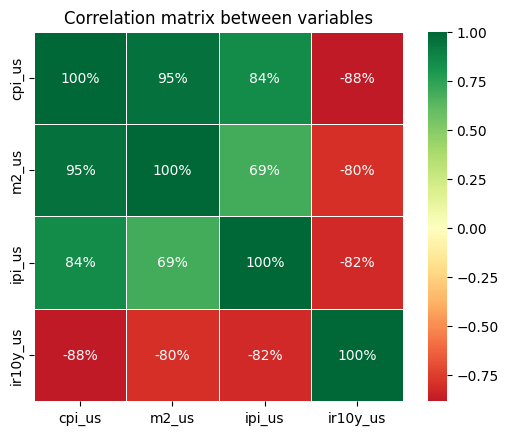

In [ ]:
#code for eda

eda(var_df_transformed)

Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise

ADF test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,cpi_us,0.946356,0.946356,0.946356
1,m2_us,1.000000,1.000000,1.000000
2,ipi_us,0.735581,0.735581,0.735581
3,ir10y_us,0.035742,0.035742,0.035742



PP test for stationarity: H0 is time series is not stationary


,Indicator,10%,5%,1%
0,cpi_us,0.998566,0.998566,0.998566
1,m2_us,1.000000,1.000000,1.000000
2,ipi_us,0.309926,0.309926,0.309926
3,ir10y_us,0.244427,0.244427,0.244427



KPSS test for stationarity: H0 is time series is stationary


<ipython-input-5-87a2ba453351>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')
<ipython-input-5-87a2ba453351>:64: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df[column], regression = 'ct')


,Indicator,10%,5%,1%
0,cpi_us,0.079783,0.079783,0.079783
1,m2_us,0.010000,0.010000,0.010000
2,ipi_us,0.010000,0.010000,0.010000
3,ir10y_us,0.020682,0.020682,0.020682


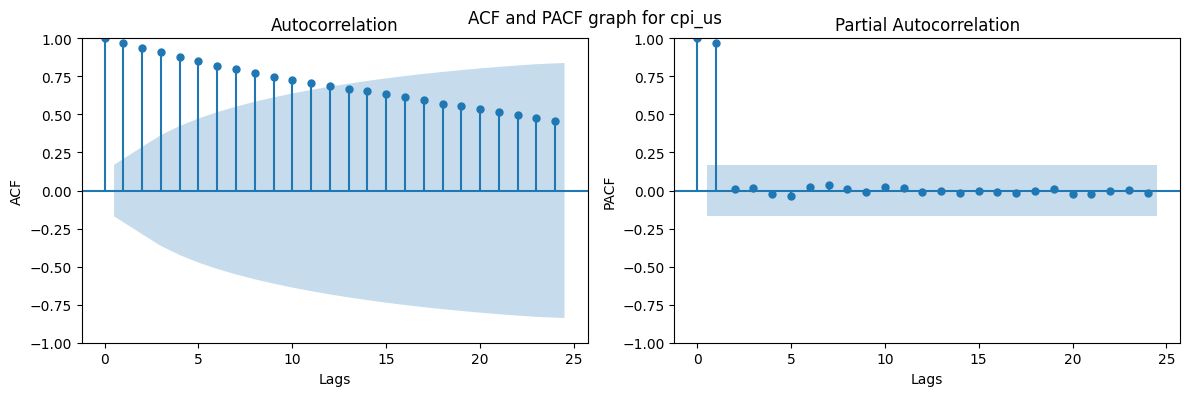

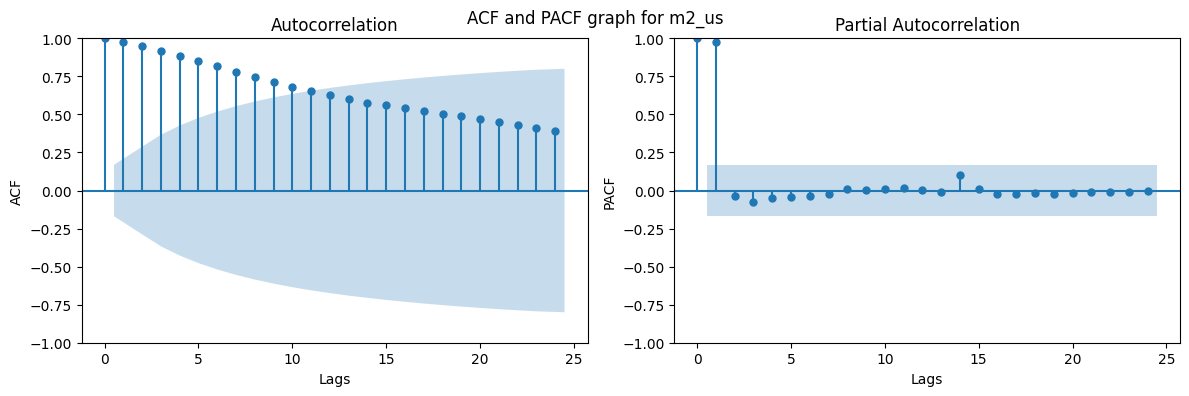

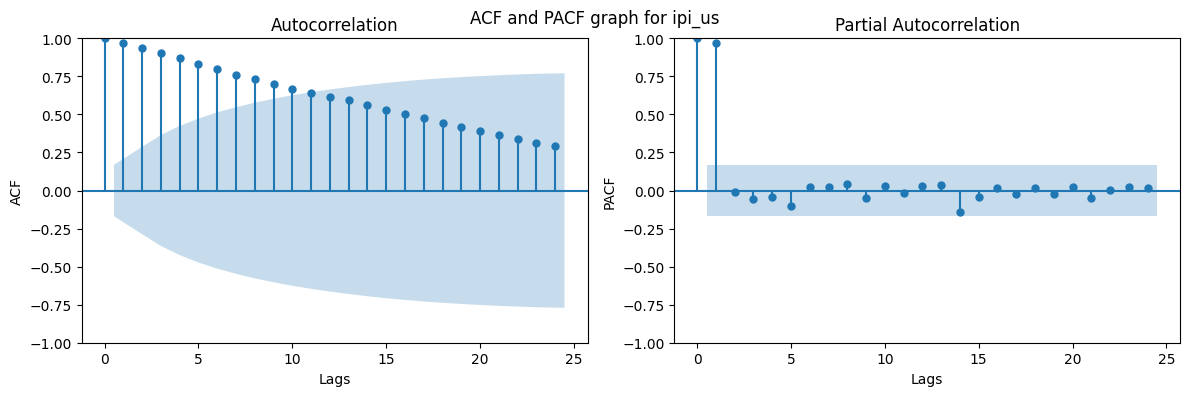

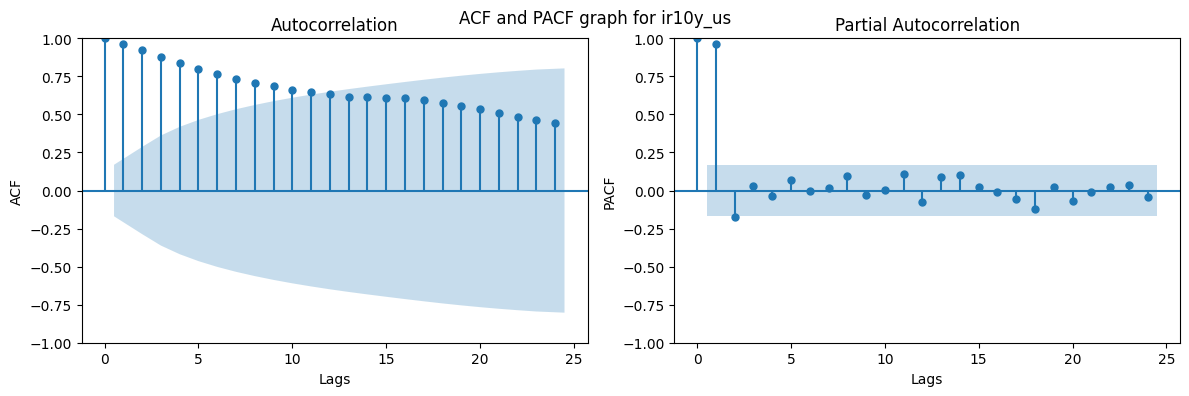

In [ ]:
# code to do stationary test

stationarity_test(var_df_transformed)
print()
print()
acf_pacf_graph(var_df_transformed);

Variables selection for the model
Enter columns to be used in model seperated by comma: ir10y_us,ipi_us,cpi_us,m2_us
Please enter the name of your main endogenous variables: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)



Model parameter setting and fitting
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>
Using 1 based on aic criterion

Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 0
1 if need to invert diff, 0 if no need to invert diff: 0



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Oct, 2023
Time:                     17:04:24
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.563275
Nobs:                     133.000    HQIC:                  0.305257
Log likelihood:          -743.430    FPE:                    1.13744
AIC:                     0.128636    Det(Omega_mle):        0.981336
--------------------------------------------------------------------
Results for equation ir10y_us
                 coefficient       std. erro

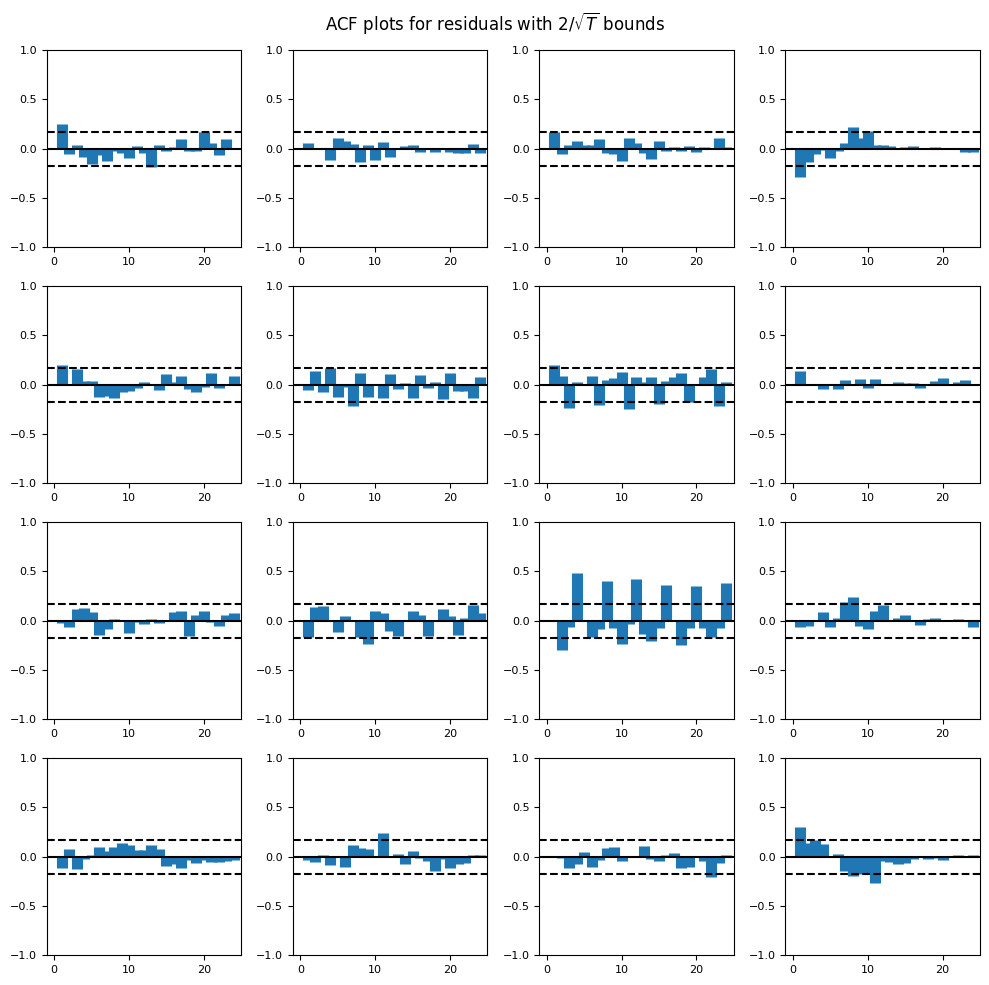




Instantaneous causality Wald-test. H_0: ['ipi_us', 'cpi_us', 'm2_us'] do not instantaneously cause ir10y_us. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         19.92          7.815   0.000  3
----------------------------------------


Granger causality F-test. H_0: ipi_us does not Granger-cause ir10y_us. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
       0.08024          3.860   0.777 (1, 512)
----------------------------------------------


Granger causality F-test. H_0: cpi_us does not Granger-cause ir10y_us. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.542          3.860   0.060 (1, 512)
----------------------------------------------


Granger causality F-test. H_0: m2_us 

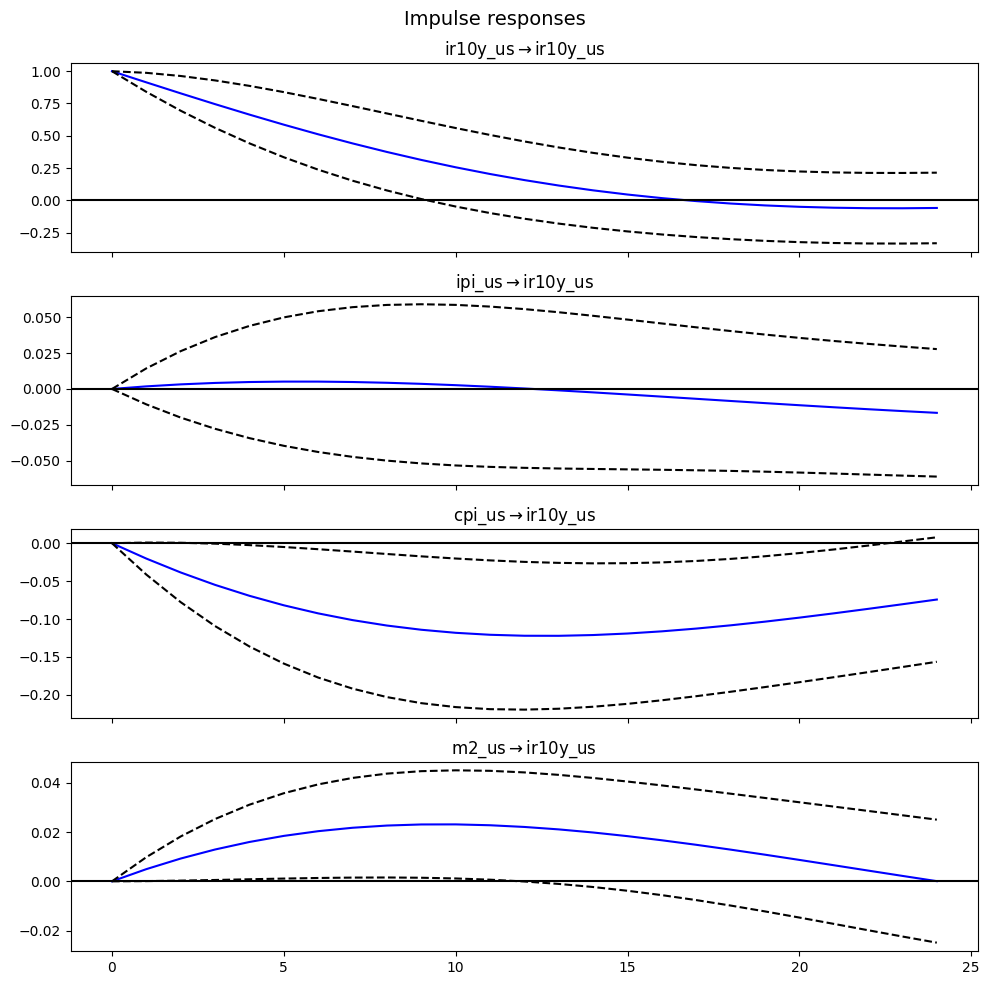

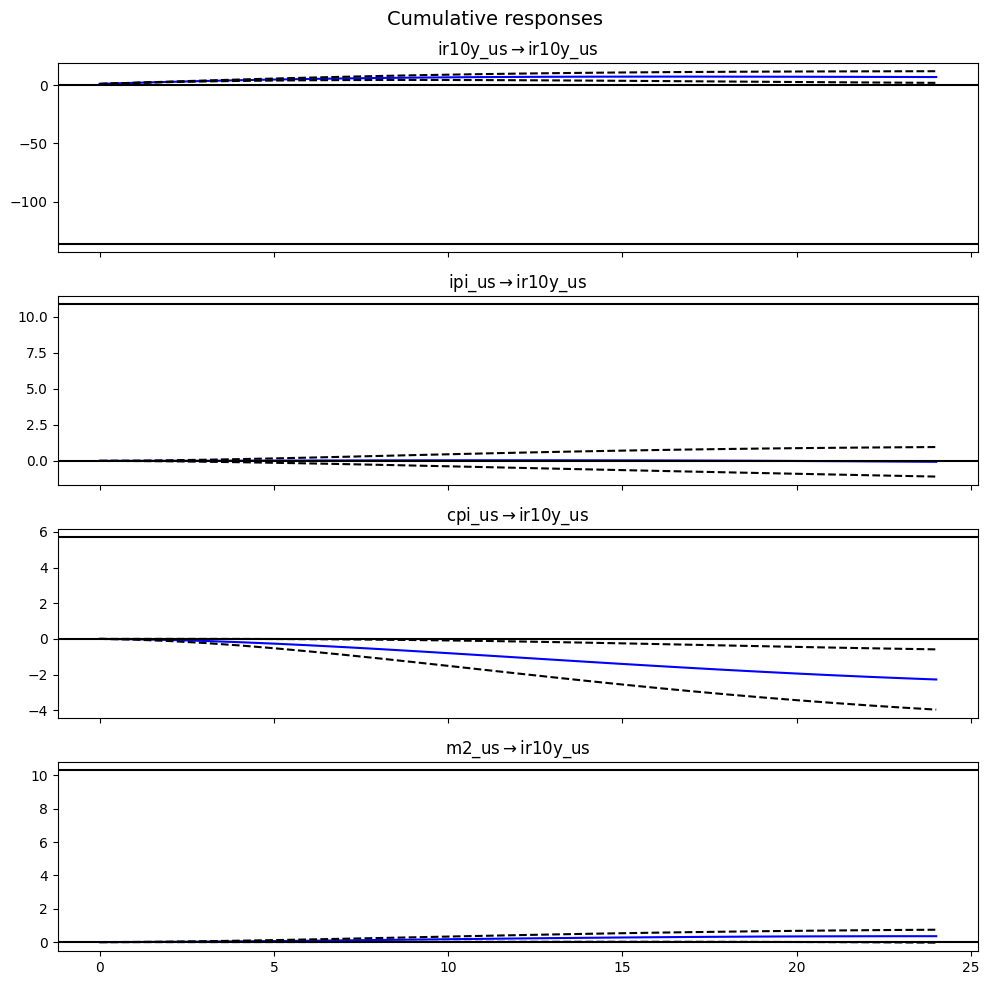

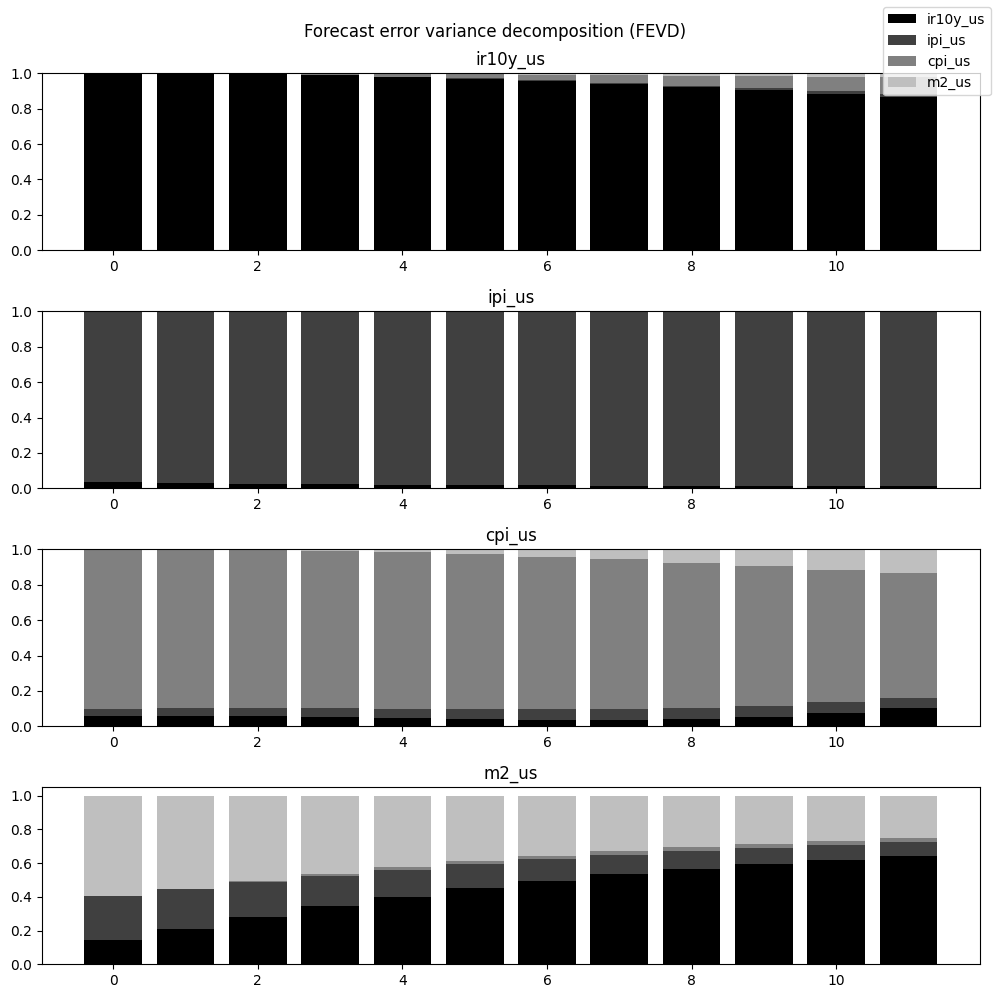





Enter the Y label name and unit ir10y_us/usd


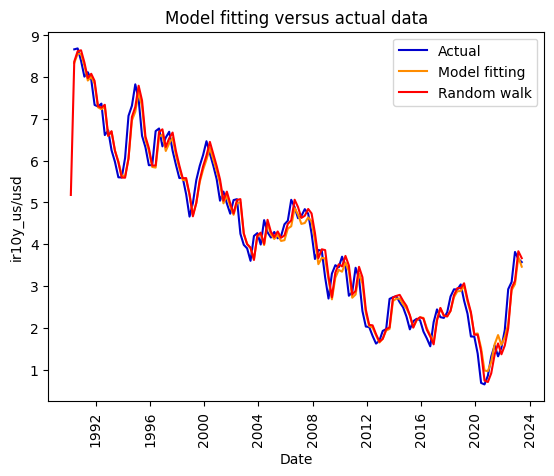



Please put model name: var
Please put dependent variable name: ir10y_us
Forecast Accuracy of: var  used to forecast  ir10y_us
mape   :  0.0908
me     :  -0.0
mae    :  0.2849
mpe    :  0.0211
rmse   :  0.3563
corr   :  0.9836
minmax :  0.0788


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.0952
me     :  0.0238
mae    :  0.3187
mpe    :  0.0208
rmse   :  0.4633
corr   :  0.973
minmax :  0.0845


In [ ]:
# Code to run VAR model

model, fit, predict, residual, actual = var_model(data)

Splitting dataset into train and test sets
Please put the desired size of your test data in decimal i.e. 20% put 0.2: 0.2

Sample transformation
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0
Please enter the name of your main endogenous variables: ir10y_us


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)



Model parameter setting and fitting
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 2, FPE -> 4, HQIC ->  4>
Using 4 based on aic criterion

Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 0
1 if need to invert diff, 0 if no need to invert diff: 0


Enter the Y label name and unit ir10y_us


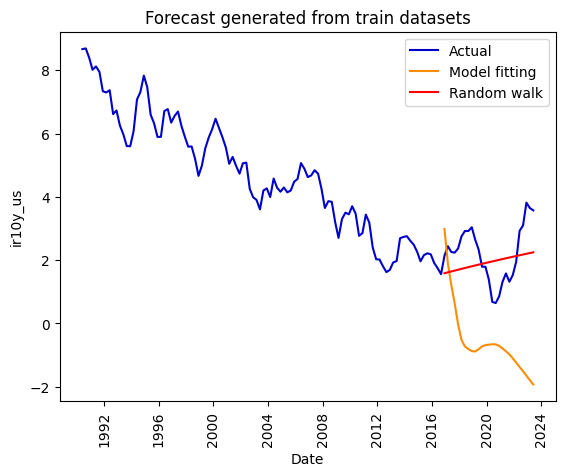



Please put model name: var
Please put dependent variable name: ir10y_us
Forecast Accuracy of: var  used to forecast  ir10y_us
mape   :  1.343
me     :  -2.7862
mae    :  2.8489
mpe    :  -1.3136
rmse   :  3.1676
corr   :  -0.1973
minmax :  1.3388


Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.4798
me     :  -0.2927
mae    :  0.8301
mpe    :  0.0919
rmse   :  0.921
corr   :  0.0788
minmax :  0.3277
RMSE for Four Quarters Ahead (VAR Model Fitting): 1.0819405399594413
RMSE for Four Quarters Ahead (Random Walk): 0.6490212579027409


In [ ]:
var_simple_validation(actual)